![logo](https://github.com/HelmholtzAI-Consultants-Munich/XAI-Tutorials/blob/main/docs/source/_figures/Helmholtz-AI.png?raw=true)

# Model-Specific Interpretation with Forest-Guided Clustering (FGC)

In this Notebook, we will demonstrate how to use the Forest-Guided Clustering (FGC) method for Random Forest models and interpret its results.

--------


## Getting Started

### Setup Colab environment

If you installed the packages and requirements on your machine, you can skip this section and start from the import section.
Otherwise, you can follow and execute the tutorial on your browser. To start working on the notebook, click on the following button. This will open this page in the Colab environment, and you will be able to execute the code on your own.

<a href="https://colab.research.google.com/github/HelmholtzAI-Consultants-Munich/XAI-Tutorials/blob/main/xai-for-random-forest/Gen_5-Tutorial_FGC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Now that you opened the notebook in Google Colab, follow the next step:

1. Run this cell to connect your Google Drive to Colab and install packages
2. Allow this notebook to access your Google Drive files. Click on 'Yes', and select your account.
3. "Google Drive for desktop wants to access your Google Account". Click on 'Allow'.
   
At this point, a folder has been created in your Drive, and you can navigate it through the lefthand panel in Colab. You might also have received an email that informs you about the access on your Google Drive.

In [1]:
# Mount drive folder to dbe abale to download repo
# from google.colab import drive
# drive.mount('/content/drive')

# Switch to correct folder'
# %cd /content/drive/MyDrive

# Don't run this cell if you already cloned the repo 
# !git clone --branch main https://github.com/HelmholtzAI-Consultants-Munich/XAI-Tutorials.git
# %cd XAI-Tutorials

# Install additional packages
# %pip install fgclustering

### Imports

Let's start with importing all required Python packages.

In [2]:
import pickle

import numpy as np
import pandas as pd

from fgclustering import FgClustering

import warnings
warnings.filterwarnings('ignore')

We fix the random seeds to ensure reproducible results, as we work with (pseudo) random numbers.

In [3]:
# assert reproducible random number generation
seed = 1
np.random.seed(seed)

--------

## Data and Model Loading: The California Housing Dataset

In this notebook, we will work with the **California Housing dataset**, containing 20,640 median house values for California districts (expressed in $100,000), which are described by eight numeric features. Each row in the dataset represents a block of houses, not a single household. The data pertains to the house prices found in a given California district and some summary statistics based on the 1990 census data. Our goal is to **predict the price** of house blocks and find the most predictive features.

<center><img src="https://github.com/HelmholtzAI-Consultants-Munich/XAI-Tutorials/blob/main/docs/source/_figures/dataset_california_housing.jpg?raw=true" width="900" /></center>

<font size=1> Source: [Link](https://www.kaggle.com/datasets/harrywang/housing)

In the notebook [*1-Tutorial_RandomForest_Models.ipynb*](./1-Tutorial_RandomForest_Models.ipynb), we explain how to do the exploratory data analysis, preprocess the data and train a Random Forest model with the given data. The focus of this notebook lies on the interpretation of the previously trained model.

In [4]:
# Load and unpack the data
with open('../models/model_rf_housing.pickle', 'rb') as handle:
    data_and_model = pickle.load(handle)

X_train = data_and_model[0]
X_test = data_and_model[1]
y_train = data_and_model[2]
y_test = data_and_model[3]
model_housing = data_and_model[4]

# is the model performing reasonably on the training data?
print(f'Model Performance on training data: {round(model_housing.score(X_train, y_train),2)} R^2.')

# is the model performing reasonably on the test data?
print(f'Model Performance on test data: {round(model_housing.score(X_test, y_test),2)} R^2.')

Model Performance on training data: 0.84 R^2.
Model Performance on test data: 0.72 R^2.


As we can see by the numbers above, our model performs well on the training set and also generalizes well to the independent test set.

*Note: you should keep in mind that interpreting a low-performing model can lead to wrong conclusions.*

*Note: The $R^2$ is the coefficient of determination, and the closer this value is to 1, the better our model explains the data. A constant model that always predicts the average target value disregarding the input features would get an $R^2$ score of 0. However, the $R^2$ score can also be negative because the model can be arbitrarily worse.*

## Now, what does my Random Forest model actually think is important in the data?

### Forest-Guided Clustering

**We prepared a small [Introduction to FGC](https://xai-tutorials.readthedocs.io/en/latest/_model_specific_xai/fgc.html) for you, to help you understand how this method works.**

<font color='green'>

#### Question 1: How is the similarity between instances calculated?

<font color='grey'>

#### Your Answer: 
The similarity represents the frequency with which two instances occur in the same terminal nodes of a tree in the Random Forest (RF) model. Intuitively, this defines how close those instances are in the RF model.

<font color='green'>

#### Question 2: How do we choose the number of cluster k for the k-medoids clustering?

<font color='grey'>

#### Your Answer: 
With a scoring system that minimizes the model bias while restricting the model complexity. The model bias measures how well the clustering (FGC with a certain value of ) approximates the expected model, while the variance is related to the model complexity, since complex models usually have a high variance and poor generalization capability.

Now let's use FGC to get some insights into the Random Forest Regression model we loaded above. FGC can help us to gain some insights into the decision-making process of the Random Forest model. We use the preprocessed dataset and trained Random Forest model as input for a FgClustering object. We have to indicate which column of the dataset contains the target values in the `target_column` parameter. 

*Note: this method is a **global** method meaning it only provides explanations for the full dataset, but not for individual examples.*

In [5]:
# create an FGC instance
fgc = FgClustering(model=model_housing, data=X_train, target_column=y_train)

Interpreting RandomForestRegressor


FGC is based on the k-medoids clustering algorithm, which requires a predefined number of clusters as input. FGC is able to optimize the number of clusters based on a scoring function, which minimizes the model bias while restricting the model complexity. The argument `number_of_clusters` is used to either pass the predefined number of clusters or should be left empty if optimization is desired. When optimizing the number of clusters, FGC calculates the score for each *k* from 2 to `max_K`. For the sake of runtime, we set `max_K` to 6.

In [6]:
# Run the fgc instance:
fgc.run(max_K=6)

 25%|██▌       | 1/4 [00:02<00:08,  2.82s/it]

For number of cluster 2 the Jaccard Index is 0.8617711047152169
For number of cluster 2 the score is 481.56000266239676


 50%|█████     | 2/4 [00:07<00:08,  4.12s/it]

For number of cluster 3 the Jaccard Index is 0.6824798434000776
For number of cluster 3 the score is 431.8881610218182


 75%|███████▌  | 3/4 [00:16<00:06,  6.17s/it]

For number of cluster 4 the Jaccard Index is 0.9111520674112253
For number of cluster 4 the score is 262.3026426922297


100%|██████████| 4/4 [00:27<00:00,  6.86s/it]

For number of cluster 5 the Jaccard Index is 0.39260500483065125
Clustering is instable, no score computed!
Optimal number of cluster is: 4
{'MedInc': 2.101187959037925e-202, 'HouseAge': 5.242283468049069e-22, 'AveRooms': 2.708405850918273e-131, 'AveBedrms': 1.3286309981602522e-08, 'Population': 4.405033353472343e-08, 'AveOccup': 1.1021362801160844e-49, 'Latitude': 1.3212022464053e-45, 'Longitude': 6.482195912908503e-53}


When training the model, we standardized the feature values beforehand. However, in the visualizations it would be nice to see the actual feature values, which is possible with FGC. Therefore, we back-transform the feature values to the original space with the scaler object that was saved during model training and then re-calculate the cluster-wise statistics in order to use the original feature values for the visualizations.

In [7]:
# get original unscaled feature values
scaler = data_and_model[5]
X_train_unscaled = scaler.inverse_transform(X_train)
X_train_unscaled = pd.DataFrame(X_train_unscaled, columns = X_train.columns)

# re-calculate the cluster-wise statistics for the unscaled features
fgc.calculate_statistics(data=X_train_unscaled, target_column=y_train)

{'MedInc': 2.101187959038164e-202, 'HouseAge': 5.242283468049069e-22, 'AveRooms': 2.708405850918273e-131, 'AveBedrms': 1.3286309981601909e-08, 'Population': 4.405033353472202e-08, 'AveOccup': 1.1021362801160844e-49, 'Latitude': 1.3212022464053e-45, 'Longitude': 6.482195912907766e-53}


FGC provides a couple of ways to visualise the results and help interpret them:

- visualise global and local feature importance: features that show different and concise value distributions across clusters are defined to be globally or locally important
- reveal the decision path of the RF model by visualizing feature patterns per cluster

### Global and Local Feature importance provided by FGC

**Global feature importance** is represented as the significance of the difference between cluster-wise feature distributions (ANOVA for continuous features and chi square for categorical features). Features with significantly different distributions across clusters have a high feature importance, while features with a similar feature distribution across clusters have a low feature importance.

In addition to the global feature importance, we also provide a **local feature importance**, which gives the importance of each feature for each cluster. For the local feature importance we pre-filter the features based on the global feature importance (`thr_pvalue` is used for the filtering step). Here, a feature is considered important if its distribution in a particular cluster differs from the feature distribution in the whole dataset.

Please note that the importance is defined as $1 - pvalue$. Therefore, the more significant difference across clusters the feature shows (the smaller the p-value), the closer the importance of the feature is to 1. 

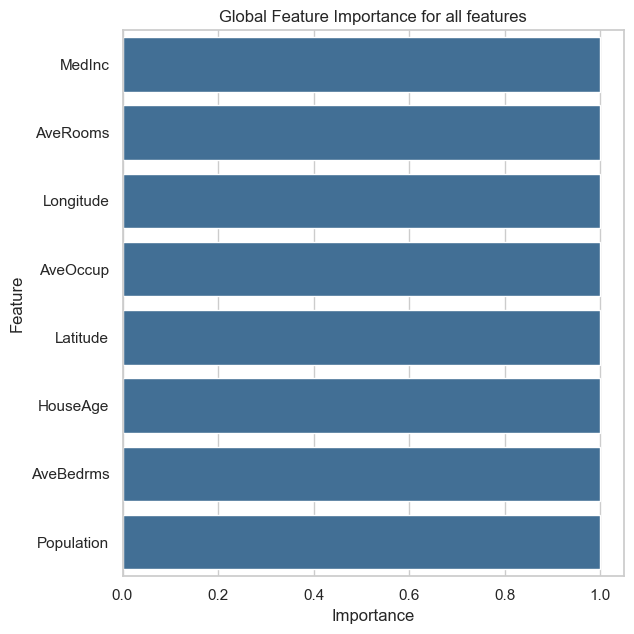

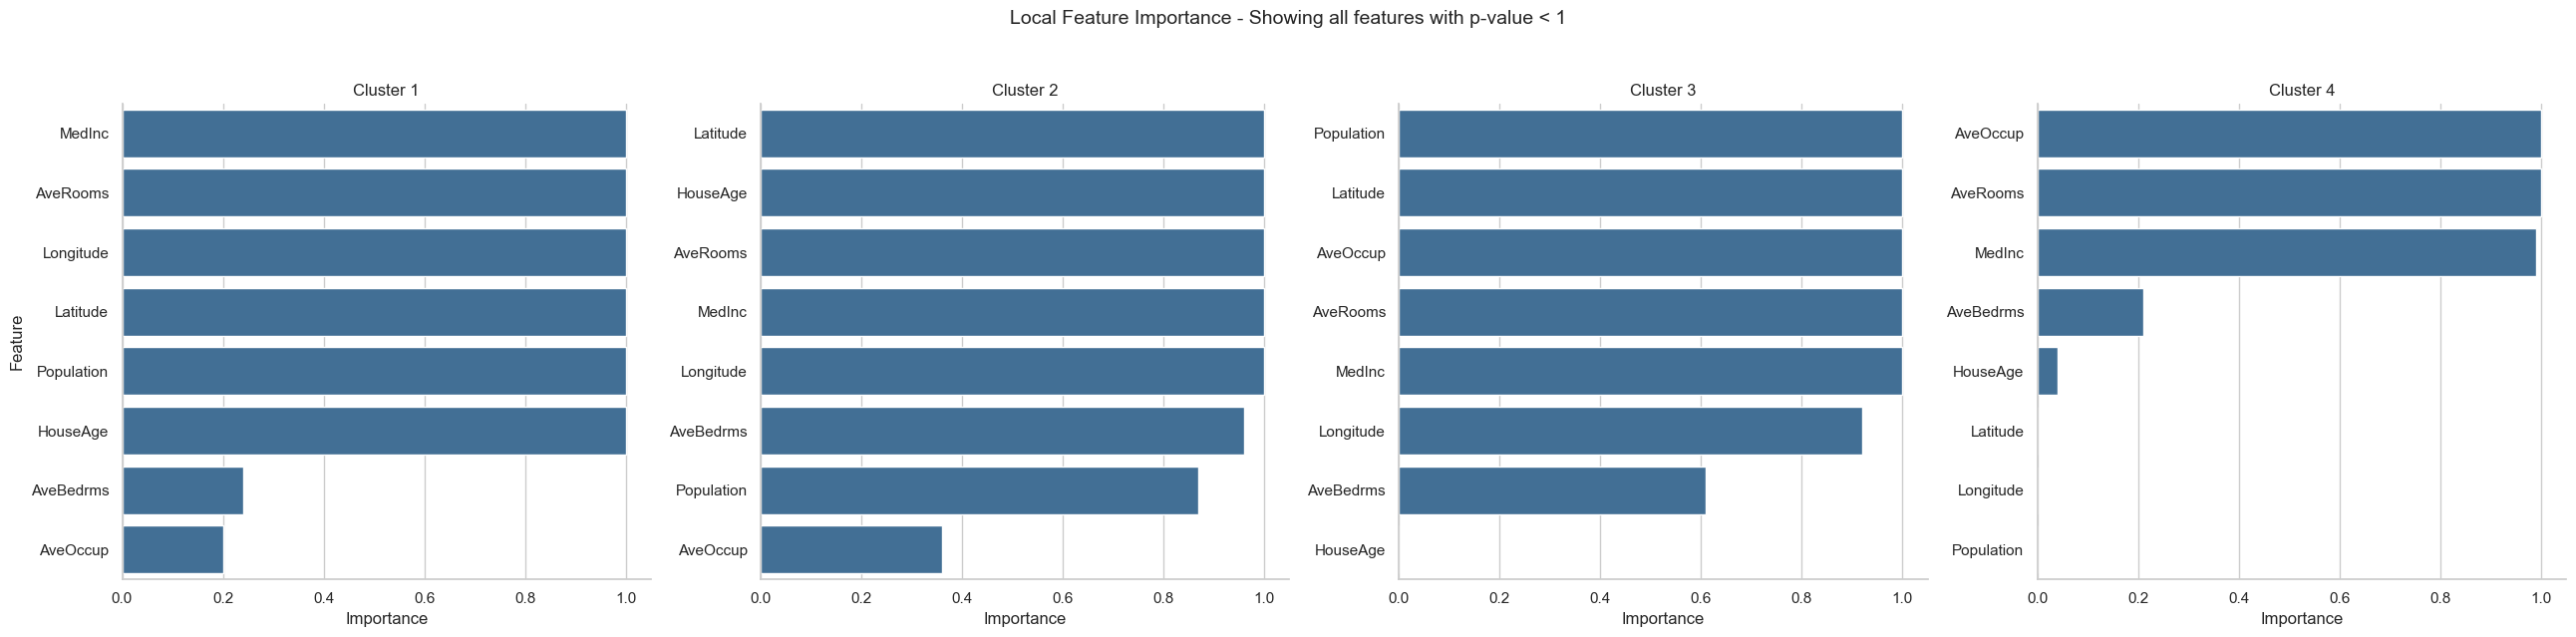

In [8]:
%matplotlib inline
# Plot global feature importance
fgc.plot_global_feature_importance()
# Plot local feature importance
fgc.plot_local_feature_importance(thr_pvalue=1) # Set thr_pvalue=1 to show all the features

The plots above indicate that while all features help to distinguish the different clusters, not all features are important for each cluster. For cluster 3, for instance, only a few features show a  different distribution from the background distribution.

### Visualizing the decision paths of the Random Forest model

Forest-Guided Clustering provides the special option to visualize the decision path of a Random Forest model, reflecting the decision-making process of that model, in a heatmap summary plot and a feature-wise distribution plot. The heatmap provides a general overview of the target value attribution and feature enrichment / depletion per cluster.  We can see which classes or target values fall into which cluster, and samples that fall into the "wrong" cluster can be inspected further as they might be extreme outliers or wrongly labeled samples / measurement errors. The distribution plots contain the same information as the heatmap but are presented in a different way. They help us understand the distribution of feature values within each cluster, e.g., having a small or high within-cluster-variation. 

We can choose which features we want to plot by specifying the p-value threshold applied to the p-values of the features from the global feature importance calculation. The default threshold `thr_pvalue` is set to 0.01. By selecting a lower p-value threshold, we only plot features that show high differences between cluster-wise feature distributions. 

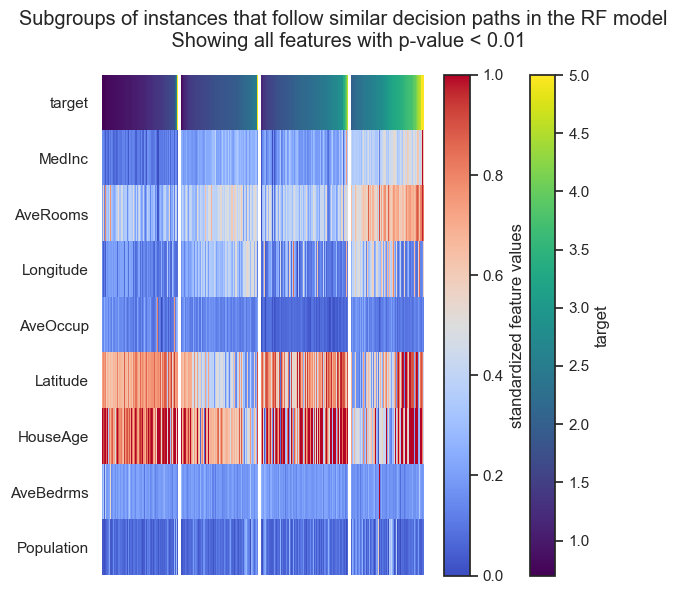

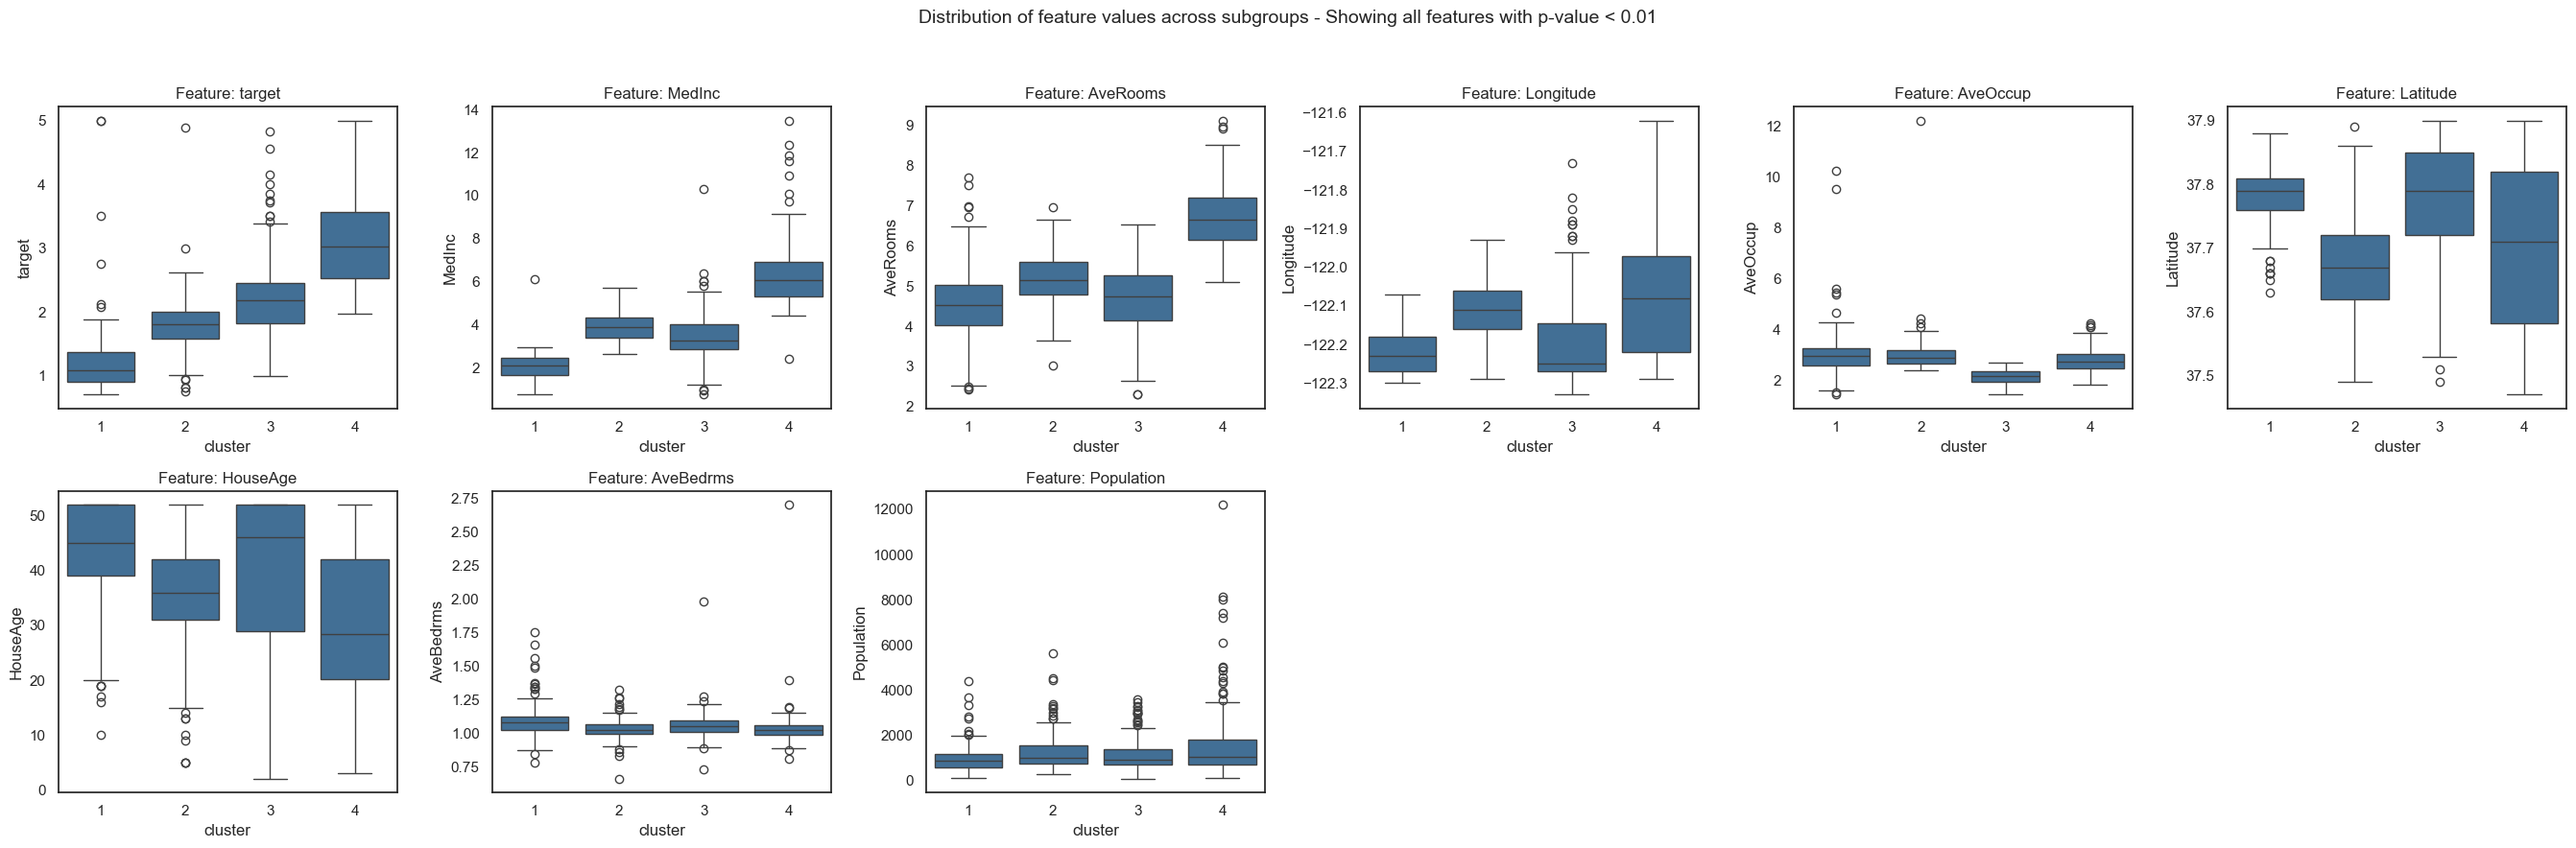

In [9]:
fgc.plot_decision_paths(thr_pvalue=0.01) # feel free to try different p-values thresholds

<font color='green'>

#### Question 3: The feature AveRooms has a high feature importance, how is its distribution across clusters?

<font color='grey'>

#### Your Answer: 
Features with significantly different value distributions across clusters have a high feature importance.

<font color='green'>

#### Question 4: Which conclusions can we draw from the decision path plots above?

<font color='grey'>

#### Your Answer: 
We have two clusters (cluster 0 and 3) which represent the extremes in the dataset, i.e. houses with very low or very high house values. The lowly valued house blocks are on average occupied by people with low median income, are located in the city center (according to long/lat) and have a high house age. In contrast, the highly valued house blocks are on average occupied by people with high median income, have many rooms but a low house age and are located outside of the city center towards the mountains (according to long/lat). The remaining two clusters (cluster 1 and 2) represent houses with intermediate values. The house blocks of both clusters are occupied by middle class people with a middle medium income, hence, those two cluster can't be distinguished by income alone. Intereastingly, the house blocks of cluster 1 have more rooms and are occupied by more people than the house blocks in cluster 2. Looking at the long/lat we can see that the house blocks of cluster 2 are located on the city center and are older, while house blocks of cluster 1 are newer and located ouside the city center but closer to the airport and further away from the mountains than the house blocks of cluster 3, which are the highly valued houses.

In conclusion, we can hypothesize that lowly valued older house blocks are located in the city center and occupied by low income people with higher occupancy and less number of rooms. Then we have more highly valued older house blocks in the city center which are occupied by middle income people, who live most likely in a single or couple household. In the same value range we have newer house blocks that are located outside the city center (but close to an airport) and are occupied by middle income people, who live most likely in a family household with more than 2 people. Last, we have the highly valued newer house blocks that have many rooms, are occupied by high income people and are located outside the city, close to the mountains but further away from the airport.